# Visualize & Compare Residuals of Ring Removal Methods

## Imports

In [1]:
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 300
import torch
from torch.nn.parallel import DataParallel as DP, DistributedDataParallel as DDP

from tomopy.prep.stripe import remove_stripe_fw, remove_stripe_based_sorting
#from larix.methods.misc import INPAINT_EUCL_WEIGHTED, INPAINT_NDF, INPAINT_NM
from tomopy.misc.corr import inpainter_morph

from network.patch_visualizer import PatchVisualizer
from network.models import MaskedGAN
from network.models.generators import PatchUNet
from network.models.discriminators import PatchDiscriminator
from utils.data_io import loadTiff, rescale
from utils.tomography import reconstruct
from utils.misc import toTensor, toNumpy

%load_ext autoreload
%autoreload 2

# Number of threads for OpenMP. If too high, may cause error
%env OMP_NUM_THREADS=16

env: OMP_NUM_THREADS=16


[home:73558] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


## Functions
TomoPy edits sinograms in-place, so we must copy the input to avoid changing it.<br>
TomoPy also expects 3D volumes to have shape `(angles, det Y, det X)` so we must swap axes 0 and 1.

In [2]:
def fourier_wavelet(sino_volume, ncore=None, **kwargs):
    inpt = sino_volume.copy().swapaxes(0, 1)
    output = remove_stripe_fw(inpt, ncore=ncore, **kwargs)
    return output.swapaxes(0, 1)

def remove_stripes_based_sorting(sino_volume, size=21, dim=1, ncore=None):
    inpt = sino_volume.copy().swapaxes(0, 1)
    output = remove_stripe_based_sorting(inpt, size, dim, ncore=ncore)
    return output.swapaxes(0, 1)

def remove_stripes_larix(sino_volume, mask, mode='NDF'):
    if mode == 'NDF':
        func = INPAINT_NDF
        kwargs = dict(regularisation_parameter=5000, edge_parameter=0, iterationsNumb=5000,
                      time_marching_parameter=0.000075, penalty_type=1)
    elif mode == 'EUCL':
        func = INPAINT_EUCL_WEIGHTED
        kwargs = dict(iterationsNumb=3, windowsize_half=2, method_type='random')
    elif mode == 'NM':
        func = INPAINT_NM
        kwargs = dict(SW_increment=2, iterationsNumb=150)
    else:
        raise ValueError(f"Mode {mode} not recognized.")
    inpainted = np.empty_like(sino_volume)
    for s in range(sino_volume.shape[0]):
        inpainted[s] = func(sino_volume[s], mask[s], **kwargs)
    return inpainted

def inpaint_stripes_tomopy(sino_volume, mask, inpainting_type='random'):
    func = inpainter_morph
    kwargs = dict(size=5,
                  iterations=5,
                  inpainting_type=inpainting_type,
                  method_type='2D')
    inpainted = np.empty_like(sino_volume)
    for s in range(sino_volume.shape[0]):
        inpainted[s] = func(sino_volume[s], mask[s].astype(bool), **kwargs)
    return inpainted

In [3]:
def load_model(path, device=None):
    # Load model state dict from disk
    checkpoint = torch.load(path, map_location=device)
    # Initialize Generator and Discriminator
    gen = DP(PatchUNet())
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc = DP(PatchDiscriminator())
    disc.load_state_dict(checkpoint['disc_state_dict'])
    # Initialize Model
    model = MaskedGAN(gen, disc, mode='test', device=device)
    return model

## Setup

### Parameters

In [4]:
i12 = Path('/media/algol/HD-LXU3/No_stripes_net_data/')
data_dir = i12/'data'/'wider_stripes'
model_file = i12/'pretrained_models'/'five_sample'/'4x4'/'val'/'five_sample_4x4_100.tar'
mask_file = i12/'stripe_masks.npz'

if torch.cuda.is_available():
    d = torch.device('cuda')
else:
    d = torch.device('cpu')

rng = np.random.default_rng()
cor = 1253
dpi_set = 50
sample_no = 0
print(f"Sample No.: {sample_no}")

Sample No.: 0


### Load Model & Visualizer

In [5]:
model = load_model(model_file, device=d)
v = PatchVisualizer(data_dir, model, sample_no=sample_no, mask_file=mask_file,
                    full_sino_size=(1801, 2560), patch_size=(1801, 256))

# Correct masks so they cover stripes better
if (data_dir == i12/'data'/'wider_stripes' and sample_no == 0) or data_dir == i12/'data'/'dynamic2' or \
(data_dir == i12/'data'/'external' and sample_no == 1):
    if data_dir == i12/'data'/'external' and sample_no == 1:
        del v.mask
        v.mask = np.load(mask_file)['m119643']
        assert v.mask.shape == (1800, 2160, 2560)
    v.mask[:, 852, 1654:1669] = 1
    v.mask[:, 852, 1089:1110] = 1
    v.mask[:, 1080, 1219:1232] = 1
    v.mask[:, 1200, 580:593] = 1
    v.mask[:, 1200, 1399:1410] = 1
    v.mask[:, 1200, 1474:1489] = 1
    v.mask[:, 1200, 1662:1679] = 1
    v.mask[:, 1200, 1875:1892] = 1
    v.mask[:, 988, 1480:1501] = 1
    v.mask[:, 419, 1019:1034] = 1
    v.mask[:, 950, 1719:1728] = 1
    v.mask[:, 1507, :] = 0
    v.mask[:, 1507, 1743:1754] = 1
    v.mask[:, 1507, 1235:1240] = 1
    v.mask[:, 1070, 624:643] = 1
    v.mask[:, 1070, 872:889] = 1
elif data_dir == i12/'data'/'external' and sample_no == 0:
    v.mask[:, 1128, :] = 0
    v.mask[:, 1128, 868:889] = 1
    v.mask[:, 1128, 1724:1735] = 1
else:
    print(f"Mask correction for '{data_dir}' is not implemented.")

# Residuals

## Synthetic Artifacts

### Sinograms 

In [6]:
sino_idx = 1214 #rng.choice(v.clean_idxs)
print(f"Sino index: {sino_idx}")

clean_sino = v.get_sinogram(sino_idx, 'clean')
stripe_sino = v.get_sinogram(sino_idx, 'stripe')
mask = np.abs(clean_sino - stripe_sino).astype(np.bool_, copy=False)

sinos = [
    stripe_sino,
    fourier_wavelet(stripe_sino[None, :, :], level=None, wname='db5', sigma=0.6, pad=True, ncore=16).squeeze(),
    remove_stripes_based_sorting(stripe_sino[None, :, :].astype(np.float32), size=31, dim=1, ncore=16).squeeze(),
    inpaint_stripes_tomopy(stripe_sino[None, :, :], mask[None, :, :]).squeeze(),
    v.get_model_sinogram(sino_idx, 'fake')
]

sino_residuals = [np.square(sino - clean_sino) for sino in sinos]

Sino index: 1214


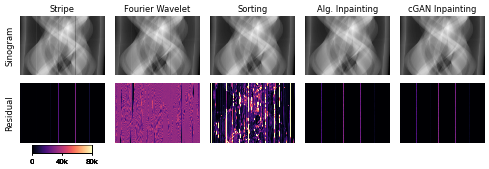

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(12, 8), dpi=dpi_set)
fig.subplots_adjust(hspace=-0.72, wspace=0.12)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0, 0].set_title("Stripe")
axs[0, 1].set_title("Fourier Wavelet")
axs[0, 2].set_title("Sorting")
axs[0, 3].set_title("Alg. Inpainting")
axs[0, 4].set_title("cGAN Inpainting")
axs[0, 0].text(-450, 900, "Sinogram", size=12, verticalalignment='center', rotation=90)
axs[1, 0].text(-450, 900, "Residual", size=12, verticalalignment='center', rotation=90)
    
for i in range(len(sinos)):
    axs[0, i].imshow(sinos[i], cmap='gray')    
    im = axs[1, i].imshow(sino_residuals[i], cmap='magma', vmin=0, vmax=80000)
    cax = fig.add_axes([0.145, 0.31, 0.1, 0.02])
    cbar = fig.colorbar(im, cax=cax, location='bottom', orientation='horizontal', ticks=[0, 40000, 80000])
    cbar.ax.set_xticklabels(['0', '40k', '80k'])
plt.savefig('synthetic_stripes_residuals.png')

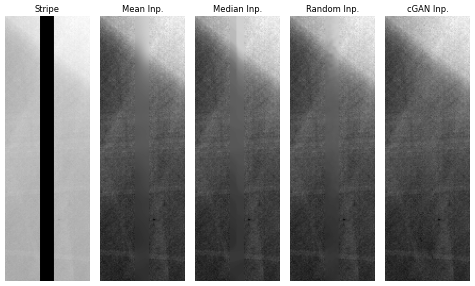

In [8]:
# Looking up close into inpainters and the cGAN result
fig, axs = plt.subplots(1, 5, figsize=(12, 8), dpi=dpi_set)
fig.subplots_adjust(hspace=-0.72, wspace=0.12)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0].set_title("Stripe")
axs[1].set_title("Mean Inp.")
axs[2].set_title("Median Inp.")
axs[3].set_title("Random Inp.")
axs[4].set_title("cGAN Inp.")

stripe_sino = sinos[0]*(1-mask)
sinos_comp = [
    stripe_sino,
    inpaint_stripes_tomopy(stripe_sino[None, :, :], mask[None, :, :], inpainting_type = 'mean').squeeze(),
    inpaint_stripes_tomopy(stripe_sino[None, :, :], mask[None, :, :], inpainting_type = 'median').squeeze(),
    inpaint_stripes_tomopy(stripe_sino[None, :, :], mask[None, :, :], inpainting_type = 'random').squeeze(),
    sinos[4],
]

for i in range(len(sinos_comp)):
    axs[i].imshow(sinos_comp[i][700:950,1120:1200], cmap='gray')
plt.savefig('inpainters_compared.png')

### Reconstructions

In [9]:
clean_recon = reconstruct(clean_sino, rot_center=cor, ncore=16)
recons = [reconstruct(sino, rot_center=cor, ncore=16) for sino in sinos]
recon_residuals = [np.square(recon - clean_recon) for recon in recons]

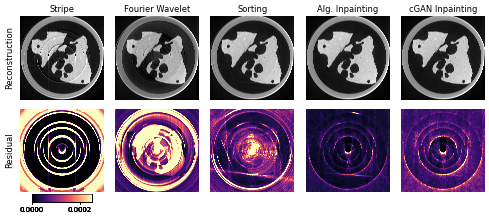

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(12, 8), dpi=dpi_set)
fig.subplots_adjust(hspace=-0.57, wspace=0.14)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0, 0].set_title("Stripe")
axs[0, 1].set_title("Fourier Wavelet")
axs[0, 2].set_title("Sorting")
axs[0, 3].set_title("Alg. Inpainting")
axs[0, 4].set_title("cGAN Inpainting")
axs[0, 0].text(-450, 1280, "Reconstruction", size=12, verticalalignment='center', rotation=90)
axs[1, 0].text(-450, 1280, "Residual", size=12, verticalalignment='center', rotation=90)
    
for i in range(len(recons)):
    axs[0, i].imshow(recons[i], cmap='gray', vmin=-0.02, vmax=0.14)
    im=axs[1, i].imshow(recon_residuals[i], cmap='magma', vmin=0, vmax=0.00025)
    cax = fig.add_axes([0.145, 0.25, 0.1, 0.02])
    fig.colorbar(im, cax=cax, location='bottom', orientation='horizontal')
plt.savefig('synthetic_stripes_recons.png')

## Real-life Artifacts

### Sinograms 

In [11]:
sino_idx = 852 #rng.choice(v.stripe_idxs)
print(f"Sino index: {sino_idx}")

stripe_sino = v.get_sinogram(sino_idx, 'raw')
mask = v.mask[:, sino_idx, :]

sinos = [
    stripe_sino,
    fourier_wavelet(stripe_sino[None, :, :], ncore=16).squeeze(),
    remove_stripes_based_sorting(stripe_sino[None, :, :].astype(np.float32), ncore=16).squeeze(),
    inpaint_stripes_tomopy(stripe_sino[None, :, :], mask[None, :, :]).squeeze(),
    v.get_model_sinogram(sino_idx, 'real')
]

sino_residuals = [np.square(sino - stripe_sino) for sino in sinos]

Sino index: 852


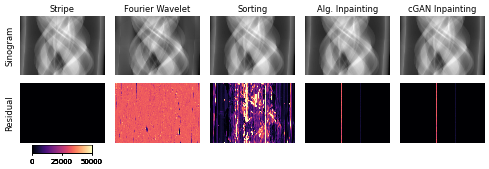

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(12, 8), dpi=dpi_set)
fig.subplots_adjust(hspace=-0.72, wspace=0.12)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0, 0].set_title("Stripe")
axs[0, 1].set_title("Fourier Wavelet")
axs[0, 2].set_title("Sorting")
axs[0, 3].set_title("Alg. Inpainting")
axs[0, 4].set_title("cGAN Inpainting")
axs[0, 0].text(-450, 900, "Sinogram", size=12, verticalalignment='center', rotation=90)
axs[1, 0].text(-450, 900, "Residual", size=12, verticalalignment='center', rotation=90)
    
for i in range(len(sinos)):
    axs[0, i].imshow(sinos[i], cmap='gray')
    im = axs[1, i].imshow(sino_residuals[i], cmap='magma', vmin=0, vmax=50000)
    cax = fig.add_axes([0.145, 0.31, 0.1, 0.02])
    fig.colorbar(im, cax=cax, location='bottom', orientation='horizontal')
plt.savefig('real_stripes_residuals.png')

#### Zoom on Stripe Region

In [13]:
roi = np.s_[:, 1000:1750]
zoomed_sinos = [sino[roi] for sino in sinos]
zoomed_sino_resduals = [sino_residual[roi] for sino_residual in sino_residuals]

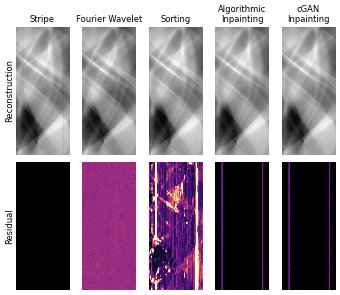

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(8, 6), dpi=dpi_set)
fig.subplots_adjust(wspace=-0.5)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0, 0].set_title("Stripe")
axs[0, 1].set_title("Fourier Wavelet")
axs[0, 2].set_title("Sorting")
axs[0, 3].set_title("Algorithmic\nInpainting")
axs[0, 4].set_title("cGAN\nInpainting")
axs[0, 0].text(-150, 900, "Reconstruction", size=12, verticalalignment='center', rotation=90)
axs[1, 0].text(-150, 900, "Residual", size=12, verticalalignment='center', rotation=90)
    
for i in range(len(sinos)):
    axs[0, i].imshow(zoomed_sinos[i], cmap='gray')
    axs[1, i].imshow(zoomed_sino_resduals[i], cmap='magma', vmin=0, vmax=75000)
    
fig.tight_layout()

### Reconstructions

In [15]:
recons = [reconstruct(sino, rot_center=cor, ncore=16) for sino in sinos]
recon_residuals = [np.square(recon - recons[0]) for recon in recons]

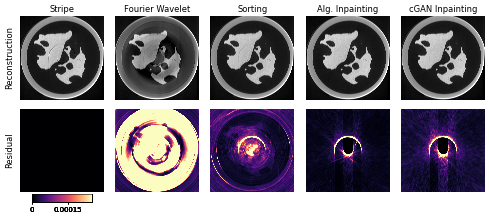

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(12, 8), dpi=dpi_set)
fig.subplots_adjust(hspace=-0.57, wspace=0.14)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0, 0].set_title("Stripe")
axs[0, 1].set_title("Fourier Wavelet")
axs[0, 2].set_title("Sorting")
axs[0, 3].set_title("Alg. Inpainting")
axs[0, 4].set_title("cGAN Inpainting")
axs[0, 0].text(-450, 1280, "Reconstruction", size=12, verticalalignment='center', rotation=90)
axs[1, 0].text(-450, 1280, "Residual", size=12, verticalalignment='center', rotation=90)
    
for i in range(len(recons)):
    axs[0, i].imshow(recons[i], cmap='gray', vmin=-0.02, vmax=0.14)
    im=axs[1, i].imshow(recon_residuals[i], cmap='magma', vmin=0, vmax=0.00025)        
    cax = fig.add_axes([0.145, 0.25, 0.1, 0.02])
    cbar = fig.colorbar(im, cax=cax, location='bottom', orientation='horizontal', ticks=[0, 0.00015])
    cbar.ax.set_xticklabels(['0', '0.00015'])
plt.savefig('real_stripes_recons.png')

#### Zoom On Ring Region

In [17]:
roi = np.s_[750:1600, 750:1810]
zoomed_recons = [recon[roi] for recon in recons]
zoomed_recon_resduals = [recon_residual[roi] for recon_residual in recon_residuals]

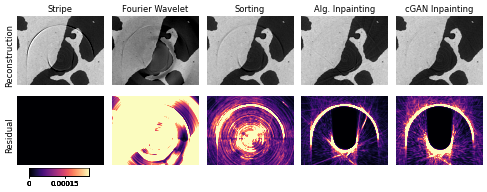

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(12, 8), dpi=dpi_set)
fig.subplots_adjust(hspace=-0.65, wspace=0.1)
for ax in axs.ravel():
    ax.axis('off')
    
axs[0, 0].set_title("Stripe")
axs[0, 1].set_title("Fourier Wavelet")
axs[0, 2].set_title("Sorting")
axs[0, 3].set_title("Alg. Inpainting")
axs[0, 4].set_title("cGAN Inpainting")
axs[0, 0].text(-150, 480, "Reconstruction", size=12, verticalalignment='center', rotation=90)
axs[1, 0].text(-150, 480, "Residual", size=12, verticalalignment='center', rotation=90)
    
for i in range(len(recons)):
    axs[0, i].imshow(zoomed_recons[i], cmap='gray', vmin=-0.02, vmax=0.14)
    axs[1, i].imshow(zoomed_recon_resduals[i], cmap='magma', vmin=0, vmax=0.00025)
    cax = fig.add_axes([0.145, 0.28, 0.1, 0.02])
    cbar = fig.colorbar(im, cax=cax, location='bottom', orientation='horizontal', ticks=[0, 0.00015])
    cbar.ax.set_xticklabels(['0', '0.00015'])
plt.savefig('zoomed_real_stripes_recons.png')